# Securities portfolio modeling. Allocation, optimization and analysis
### Kirill Zakharov
#### telegram: @kirillzx

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sts
import yfinance as yf
from scipy.optimize import linprog
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.style.use('ggplot')

In [233]:
class Portfolio:
    def __init__(self, names, dates):
        self.n = len(names)
        self.names = names
        self.data = pd.DataFrame()
        self.new_data = pd.DataFrame()
        self.w = np.array([1/self.n]*self.n)
        self.month_return = 0
        self.month_COV = 0
        self.month_risk = 0
        
    def get_ts(self):
        self.data = pd.DataFrame(columns=self.names)
        for name in self.names:
            self.data[name] = yf.download(name, dates[0], dates[1])['Adj Close']
            
    def graphics(self):
        if self.data.empty:
            print('At first, use get_ts() for download data')
        else:
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            (self.data.pct_change()+1).cumprod().plot(ax=ax)
            plt.show()
            
    def resample_to_months(self):
        self.new_data = self.data.resample('M').last()
    
    def get_month_return(self):
        self.month_return = self.new_data.pct_change().mean()
        return self.month_return
    
    def get_month_COV(self):
        self.month_COV = self.new_data.pct_change().cov()
        return self.month_COV
    
    def get_month_risk(self, w):
        self.month_risk = np.dot(np.dot(w, self.get_month_COV()), w)
        return self.month_risk
    
    def get_returnP(self):
        return np.dot(self.w, self.get_month_return())
    
    def get_riskP(self):
        return np.dot(np.dot(self.w, self.get_month_COV()), self.w)

In [234]:
class OptimizationP(Portfolio):
    def __init__(self, names, dates):
        super().__init__(names, dates)
        self.bnds = tuple([(0.05, 0.15) for i in range(self.n)])
        self.init = np.repeat(0.05, self.n)
        self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
        self.opt1 = 0
        
    def get_help(self):
        print('maxReturn - maximize return of the portfolio\nminRisk - minimize risk of the portfolio',\
              '\nmaxSharpe - maximize a Sharpe ratio')    
    
    def optimizeP(self, type_opt, boundsP, initP, rf):
        if type_opt == 'maxReturn':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(lambda x: -np.dot(x, self.get_month_return()), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minRisk':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(lambda x: np.dot(np.dot(x, self.get_month_COV()), x), self.init,\
                                 method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSharpe':
            
            def sharpe_f(x):
                return -(np.dot(self.get_month_return(), x) - rf)/np.dot(np.dot(x, self.get_month_COV()), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxGenFun':
            t = 0.1
            
            def genFun(x):
                return -t * np.dot(self.get_month_return(), x) + 0.5 * np.dot(np.dot(x, self.get_month_COV()), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(genFun, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        else:
            return 'Choose the type of optimization. Use Object.get_help() to learn more.'

In [73]:
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL']
dates = ('2018-01-01', '2021-02-01')
portfolio1 = Portfolio(names, dates)

In [74]:
portfolio1.get_ts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [75]:
portfolio1.data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL
Date,,,,,,,,,
2018-01-03,154.489380,107.051125,197.995163,5095.507324,26.139996,0.638334,127.199066,70.177948,41.373032
2018-01-04,159.086075,110.039169,202.738434,5208.654297,26.392916,0.650833,134.899857,71.621933,41.565216
2018-01-05,158.952835,111.035172,202.199417,5283.299316,26.435070,0.654023,133.450317,71.621933,42.038452
2018-01-09,160.151993,113.367302,203.421158,5185.867676,26.528746,0.654885,136.349426,71.116539,41.877506


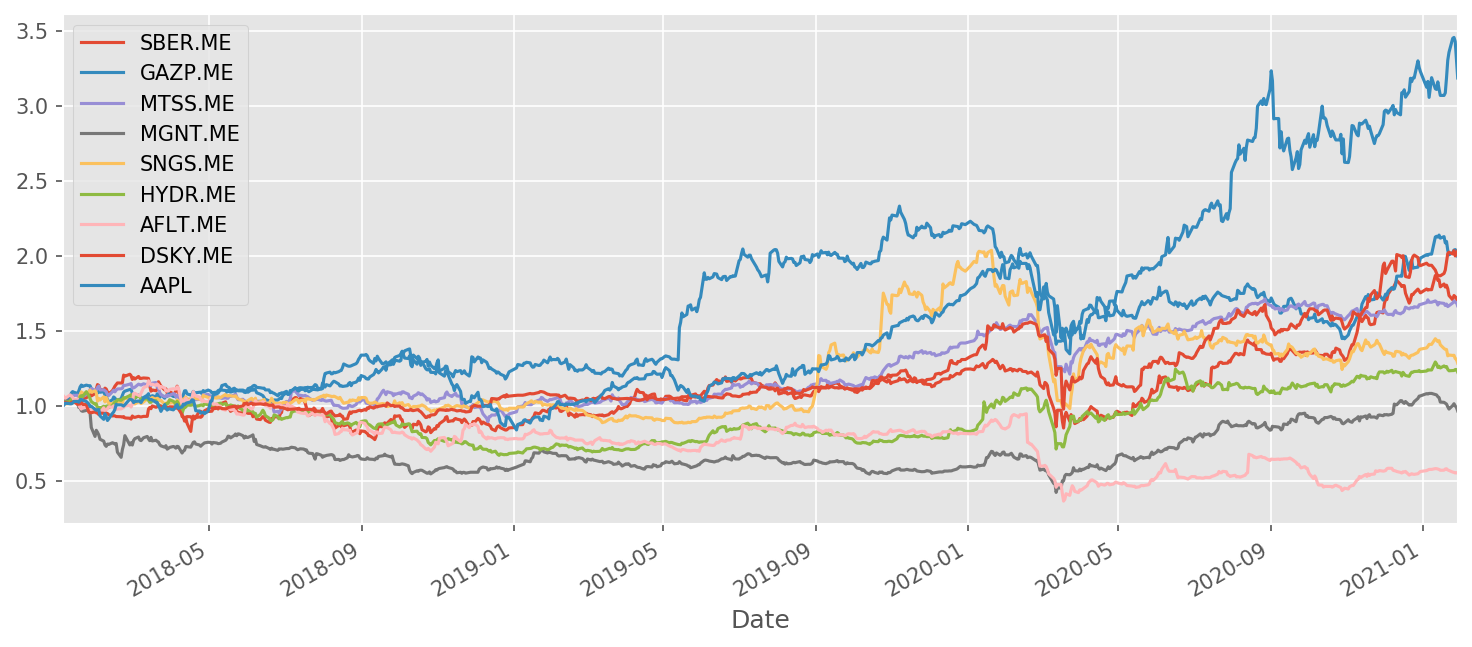

In [185]:
portfolio1.graphics()

In [76]:
portfolio1.resample_to_months()
portfolio1.new_data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL
Date,,,,,,,,,
2018-01-31,176.207153,116.088120,222.070801,4187.981445,26.922180,0.625404,120.766647,66.784569,40.219990
2018-02-28,181.470032,115.926170,221.064667,3757.396973,26.898762,0.673677,128.150345,65.340576,42.962379
2018-03-31,168.925705,115.254066,211.398468,3677.251709,26.575584,0.663678,140.969910,69.636444,40.468391
2018-04-30,151.218384,118.169220,213.015472,3851.685303,27.577906,0.642213,130.460587,67.434357,39.860565


In [77]:
portfolio1.get_month_return()

SBER.ME    0.014551
GAZP.ME    0.020665
MTSS.ME    0.012054
MGNT.ME    0.007828
SNGS.ME    0.009364
HYDR.ME    0.008317
AFLT.ME   -0.008443
DSKY.ME    0.024201
AAPL       0.038216
dtype: float64

In [78]:
portfolio1.get_month_COV()

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL
SBER.ME,0.008049,0.003786,0.002409,0.002974,0.002677,0.002823,0.005835,0.004609,0.002980
GAZP.ME,0.003786,0.007864,0.001618,0.001082,0.003177,0.000605,0.004480,0.002025,0.001375
MTSS.ME,0.002409,0.001618,0.002148,0.001639,0.001617,0.001743,0.002390,0.001186,0.002511
MGNT.ME,0.002974,0.001082,0.001639,0.007118,0.000584,0.002970,0.002996,0.001977,0.002612
SNGS.ME,0.002677,0.003177,0.001617,0.000584,0.007086,0.000244,0.003942,0.001540,0.002735
HYDR.ME,0.002823,0.000605,0.001743,0.002970,0.000244,0.004628,0.002658,0.002480,0.002215
AFLT.ME,0.005835,0.004480,0.002390,0.002996,0.003942,0.002658,0.012872,0.004946,0.004780
DSKY.ME,0.004609,0.002025,0.001186,0.001977,0.001540,0.002480,0.004946,0.006304,0.001859
AAPL,0.002980,0.001375,0.002511,0.002612,0.002735,0.002215,0.004780,0.001859,0.009755


In [79]:
portfolio1.get_month_risk(portfolio1.w)

0.0030862294492230995

In [242]:
porfolio_opt = OptimizationP(names, dates)
porfolio_opt.get_help()

maxReturn - maximize return of the portfolio
minRisk - minimize risk of the portfolio 
maxSharpe - maximize a Sharpe ratio


In [243]:
porfolio_opt.get_ts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [244]:
porfolio_opt.resample_to_months()

In [245]:
porfolio_opt.w

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [246]:
print(f'Return: {round(porfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(porfolio_opt.get_riskP()*100, 3)} %')

Return: 1.408 %
Risk: 0.309 %


In [253]:
porfolio_opt.optimizeP('maxSharpe', (0.05, 0.15), 0, 0.01)

     fun: -2.6222724020359403
     jac: array([ 1.59070382, -2.17725953, -0.83429545,  1.46588701,  1.30840445,
        1.1764833 , 11.49529561, -3.47279146, -7.37960336])
 message: 'Optimization terminated successfully.'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.05, 0.15, 0.15, 0.05, 0.1 , 0.15, 0.05, 0.15, 0.15])

In [254]:
print(f'Return: {round(porfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(porfolio_opt.get_riskP()*100, 3)} %')

Return: 1.715 %
Risk: 0.273 %


In [ ]:
def simulation():
    
    return 